In [1]:
import numpy as np
import pandas as pd

# Patient Segmentation using K-means

K-means algo:
- assign k centroids
- calculate distance of each object from each centroid
- assign each object to the closest centroid
- recalculate the position of the k centroids to minimize intra-cluster and maximize inter-cluster distance
- repeat until the centroids no longer change

K-means++  has better initialization of the centroids

Elbow Method:

It involves plotting the within-cluster sum of squares (WCSS) for different cluster numbers and identifying the “elbow” point where WCSS starts to level off

# Why Cluster PCA Results?
- Reduced Complexity: PCA reduces the dimensionality of the data, which often makes clustering more effective and interpretable.
- Uncovering Patterns: Clustering on PCA-transformed data can reveal patterns and groupings that might not be obvious in the high-dimensional original data.

Let's read the dataset

Our goal is to use K-means to find patterns between patients

In [2]:
df = pd.read_csv("/Users/simoneboesso/Desktop/PatientSegmentationCancer/leukemia_cancer_cell.tsv",sep="\t",on_bad_lines= "skip")

In [3]:
df.shape

(942, 68)

In [4]:
df.columns
# Cancer types for a multi-class classification 

Index(['Study ID', 'Patient ID', 'Sample ID', 'Age at Diagnosis',
       'Age At Specimen Acquisition', 'FLT3-ITD Allelic Ratio', 'ASXL1',
       'Cancer Type', 'Cancer Type Detailed', 'Cause Of Death',
       'CEBPA bi-allelic', 'Center ID', 'Cohort', 'Cumulative Chemo',
       'Unique Regiments', 'No. Of Cumulative Regiments',
       'Unique Treatment Stages', 'No. Of Unique Treatment Stages',
       'Unique Treatment Types', 'No. Of Cumulative Treatments',
       'Current Regimen', 'Current Stage',
       'Disease Stage At Specimen Collection', 'Diagnosis At Inclusion',
       'ELN2017', 'Ethnicity Category', 'FAB BLAST morphology', 'FLT3-ITD',
       'De Novo', 'Relapsed', 'Transformed', 'Karyotype',
       'Most Recent Treatment Duration', 'Most Recent Treatment Type',
       'Mutation Count', 'Diagnosis non AML, MDS, MPN', 'NPM1',
       'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status',
       'Other Cytogenetics', 'Prior Non-Myeloid', 'Prior Malignancy Rad

In [5]:
df.dtypes

Study ID                        object
Patient ID                      object
Sample ID                       object
Age at Diagnosis               float64
Age At Specimen Acquisition    float64
                                ...   
TMB (nonsynonymous)            float64
TP53 Pathway                    object
Treatment Type Induction        object
Used In Manuscript              object
Variant Summary                 object
Length: 68, dtype: object

In [6]:
nan_counts = df.isna().sum()
for column, count in nan_counts.items():
    print(f"Column '{column}': {count} NaN values")

Column 'Study ID': 0 NaN values
Column 'Patient ID': 0 NaN values
Column 'Sample ID': 0 NaN values
Column 'Age at Diagnosis': 26 NaN values
Column 'Age At Specimen Acquisition': 16 NaN values
Column 'FLT3-ITD Allelic Ratio': 78 NaN values
Column 'ASXL1': 842 NaN values
Column 'Cancer Type': 0 NaN values
Column 'Cancer Type Detailed': 0 NaN values
Column 'Cause Of Death': 32 NaN values
Column 'CEBPA bi-allelic': 896 NaN values
Column 'Center ID': 0 NaN values
Column 'Cohort': 0 NaN values
Column 'Cumulative Chemo': 0 NaN values
Column 'Unique Regiments': 78 NaN values
Column 'No. Of Cumulative Regiments': 2 NaN values
Column 'Unique Treatment Stages': 78 NaN values
Column 'No. Of Unique Treatment Stages': 2 NaN values
Column 'Unique Treatment Types': 78 NaN values
Column 'No. Of Cumulative Treatments': 2 NaN values
Column 'Current Regimen': 2 NaN values
Column 'Current Stage': 2 NaN values
Column 'Disease Stage At Specimen Collection': 29 NaN values
Column 'Diagnosis At Inclusion': 0 Na

Let's remove the columns with too many Nans

In [7]:
df.drop(["RUNX1","Other Cytogenetics","Type Non-Myeloid","FAB BLAST morphology","Response To Induction","Race Category","Treatment Type Induction","Ethnicity Category","Surface Antigens Immunohistochemical Stains","Response Duration To Induction","ASXL1","TP53 Pathway", "CEBPA bi-allelic","Variant Summary"], axis = 1, inplace=True)

In [8]:
df_cleaned = df.dropna().copy()
df_cleaned.shape

(675, 54)

Let's extract the info about the patient id

In [9]:
ids = df_cleaned.iloc[:,:3]
ids.head()
df_cleaned.drop(["Study ID","Patient ID", "Sample ID"], axis = 1, inplace=True)

In [10]:
df_cleaned.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,65.0,65.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Treatment,2,Waves1+2,Yes,Decitabine,...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Bone Marrow Aspirate,0,0.900000,Yes
1,68.0,68.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,5,Waves1+2,Yes,AG-221|Azacitidine|Clofarabine,...,1,Male,MATCHED,False,AML with myelodysplasia-related changes,Post-Chemotherapy|Residual Disease,Bone Marrow Aspirate,34,1.033333,Yes
3,75.0,75.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,Hydroxyurea|Decitabine,...,1,Male,MATCHED,False,Therapy-related myeloid neoplasms,Initial Acute Leukemia Diagnosis|Post-Chemothe...,Bone Marrow Aspirate,0,0.500000,Yes
4,52.0,53.0,0.0,Leukemia,Acute Leukemias of Ambiguous Lineage,Dead-Disease,1,Both,Yes,"7+3 (Cytarabine, Idarubicin)|Sunitinib|HAM (Cy...",...,1,Male,UNMATCHED,False,"Mixed phenotype acute leukaemia, T/myeloid, NOS",Post-Transplant|Post-Chemotherapy|Residual Dis...,Peripheral Blood,234,0.066667,No
6,53.0,53.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,"Fludarabine, Melphalan|7+3 (Cytarabine, Idarub...",...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Leukapheresis,0,1.200000,Yes


In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class LabelEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}
        self.indexes = []

    def fit(self, X, y=None):
        for column in X.columns:
            if X[column].dtype == "object":
                le = LabelEncoder()
                le.fit(X[column])
                self.label_encoders[column] = le
                self.indexes.append(column)
        
        return self

    def transform(self, X):
        X_encoded = X.copy()
        for column, le in self.label_encoders.items():
            X_encoded[column] = le.transform(X[column])
        return X_encoded
    


    def inverse_transform(self, X):
        X_decoded = X.copy()
        for column, le in self.label_encoders.items():
            encoded_labels = X_decoded[column]
            X_decoded [column] = le.inverse_transform(encoded_labels)
            
        return  X_decoded

Let's convert the objects types to string and then perform a label encoding!

In [12]:
''' This iterate on each column, convert to string and then perform the label encoding! 
'''
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler

encoder = LabelEncoderTransformer()
encoder.fit(df_cleaned)
df_tra = encoder.transform(df_cleaned)
df_tra.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,65.0,65.0,0.0,0,1,3,2,1,1,252,...,1,1,0,False,5,0,0,0,0.900000,1
1,68.0,68.0,0.0,0,1,1,5,1,1,156,...,1,1,0,False,6,13,0,34,1.033333,1
3,75.0,75.0,0.0,0,1,1,1,1,1,353,...,1,1,0,False,25,1,0,0,0.500000,1
4,52.0,53.0,0.0,0,0,1,1,0,1,141,...,1,1,1,False,21,17,2,234,0.066667,0
6,53.0,53.0,0.0,0,1,1,1,1,1,290,...,1,1,0,False,5,0,1,0,1.200000,1


Let's normalize!

In [13]:
scaler = StandardScaler()
standardized_df = scaler.fit_transform(df_tra)
standardized_df = pd.DataFrame(standardized_df,columns=df_cleaned.columns)


# Principal Component Analysis

Let's first find the best number of components to use!

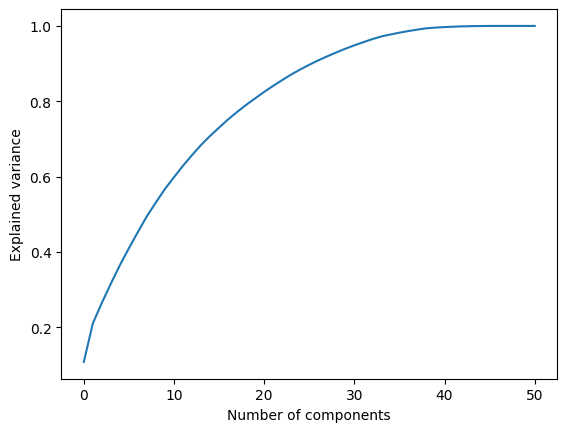

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA().fit(standardized_df)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Explained variance")
plt.show()


Let's extract the dataset we'll use for the clustering after feature reduction

In [15]:
# We can do this to get the number of components that reach 0.8 of total variance
pca = PCA(n_components=0.8)
pca.fit(standardized_df)
reduce_df = pca.transform(standardized_df)
reduce_df = pd.DataFrame(reduce_df,columns=[f'Component{i}'for i in range(1,21)])
reduce_df.shape

(675, 20)

Clearly the dataset has less columns

# K-Means

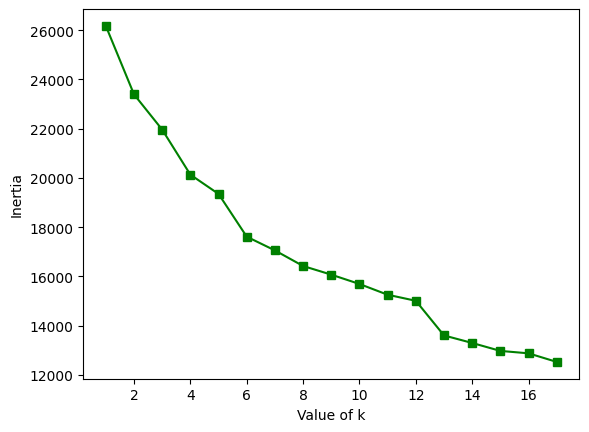

In [16]:
from sklearn.cluster import KMeans

inertia_scores = []
for i in range(1,18):
    model = KMeans(n_clusters=i, init = "k-means++",random_state=42)
    model.fit(reduce_df)
    inertia_scores.append(model.inertia_)

plt.plot(range(1,18),inertia_scores, 'gs-')
plt.xlabel("Value of k")
plt.ylabel("Inertia")
plt.show()

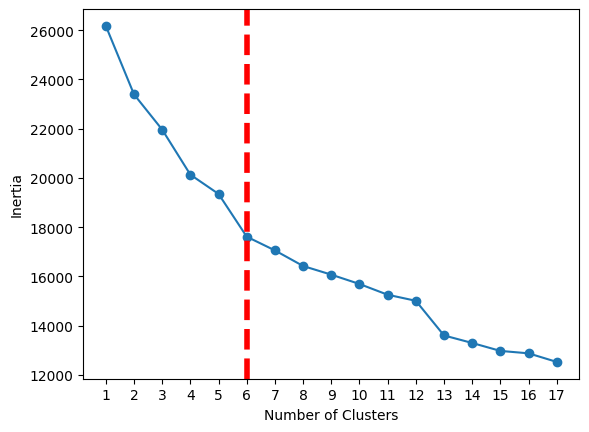

In [17]:
from kneed import KneeLocator
k1 = KneeLocator (range (1, 18), inertia_scores, curve = "convex", direction = "decreasing")
plt.plot (range (1,18), inertia_scores , marker = 'o')
plt.xticks (range (1, 18))
plt.xlabel ("Number of Clusters")
plt.ylabel ("Inertia")
plt.axvline (x = k1.elbow, color = "red", label = "axvline - full height",linewidth = 4, linestyle ="--")
plt.show()

In [18]:
model = KMeans(n_clusters=6, random_state=42).fit(reduce_df)
preds = model.predict(reduce_df)
centers = model.cluster_centers_

Now for visualization reasons, let's take the first and second components

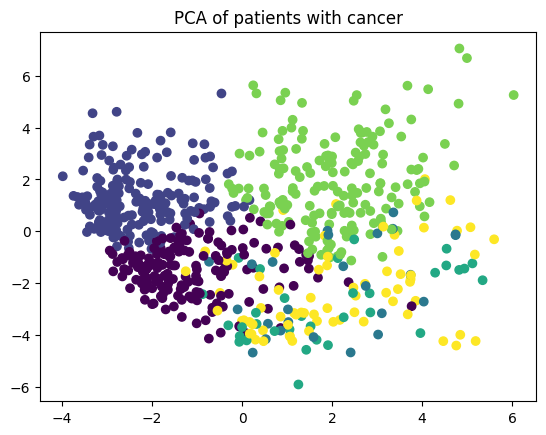

In [19]:
plt.scatter(reduce_df["Component1"],reduce_df["Component2"],c = preds)
plt.title("PCA of patients with cancer")
plt.show()

Let's try the same but in 3-D

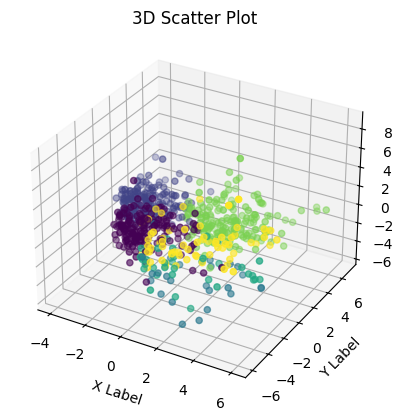

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = reduce_df["Component1"]
y = reduce_df["Component2"]
z = reduce_df["Component3"]

ax.scatter(x, y, z,c = preds)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')

plt.show()

Let's combine now the PCA dataset with the scaled

In [21]:
combined_df = pd.concat([reduce_df, standardized_df], axis=1)
combined_df.head()

,Component1,Component2,Component3,Component4,Component5,Component6,Component7,Component8,Component9,Component10,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,-1.645560,-2.037179,0.770115,-1.828658,-0.335993,0.291424,-0.718385,0.150951,-0.810652,-1.612482,...,-0.54326,0.886405,-0.824078,0.0,-0.557871,-0.661085,-0.805930,-0.302513,0.931756,0.504625
1,3.355544,-2.705670,2.173657,2.164320,-0.090696,-1.008254,-1.110164,0.975345,-1.382686,0.800064,...,-0.54326,0.886405,-0.824078,0.0,-0.404485,0.774812,-0.805930,-0.099089,1.215892,0.504625
2,0.576149,-2.994170,0.493527,-2.051835,1.447436,-0.181799,0.117820,0.369630,2.538914,0.341824,...,-0.54326,0.886405,-0.824078,0.0,2.509851,-0.550632,-0.805930,-0.302513,0.079348,0.504625
3,2.899312,3.653722,2.149217,1.777190,14.211093,7.381966,2.044548,-2.462377,-3.609694,0.543529,...,-0.54326,0.886405,1.213477,0.0,1.896307,1.216626,1.266461,1.097525,-0.844095,-1.981668
4,-1.753066,0.867685,2.014717,-0.411415,-1.610815,2.033385,-1.402216,0.588061,-0.196740,-0.666826,...,-0.54326,0.886405,-0.824078,0.0,-0.557871,-0.661085,0.230266,-0.302513,1.571062,0.504625


Let's add another layer to our analysis, analysing the loadings.

The loadings are coefficients that describe how each principal component is a combination of the original features.

In [22]:
# Get the PCA components (loadings)
pca_components_loads = pca.components_

# Create a DataFrame for better visualization and analysis
pca_loadings_df = pd.DataFrame(pca_components_loads, columns=standardized_df.columns,index=[f'PC{i}' for i in range(1,21)])

# Display the loadings
pca_loadings_df.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
PC1,0.115935,0.127735,0.083604,5.551115e-17,0.010364,0.154047,0.031968,-0.073586,-0.054302,0.065389,...,0.205166,0.052044,0.085007,-0.000000e+00,0.054841,0.306479,0.084369,0.178802,0.050063,-0.223869
PC2,-0.301896,-0.292274,0.089665,0.000000e+00,-0.049300,-0.090879,-0.113297,-0.008946,0.128772,-0.020857,...,0.143027,-0.098213,0.141121,0.000000e+00,-0.012568,0.127432,0.020107,0.171448,-0.128179,-0.142569
PC3,0.008972,0.009895,-0.098642,1.040834e-16,-0.092683,0.031147,-0.015818,-0.191085,0.115571,-0.072543,...,0.005407,0.061641,-0.361894,9.403955e-38,0.125499,0.057553,-0.106312,-0.005948,0.467740,0.006187
PC4,-0.134617,-0.134853,-0.204941,-1.110223e-16,-0.089515,-0.041556,0.060105,0.118649,0.150350,0.088813,...,-0.102360,0.044055,0.114386,3.291384e-37,0.053551,-0.031728,0.013445,0.002496,-0.128114,0.053851
PC5,0.033372,0.034283,-0.029974,3.330669e-16,-0.489051,0.007938,0.003751,0.074670,-0.046395,-0.054750,...,-0.089676,0.017574,0.130073,3.009266e-36,0.188533,0.014239,0.099451,-0.017006,-0.157114,0.035824


In [23]:
# Find the absolute values of loadings for each principal component
absolute_loadings = np.abs(pca_components_loads)

# Find the indices of the top 3 loadings for each principal component
top_2_indices = np.argsort(absolute_loadings, axis=1)[:, -2:]

# Get the column names corresponding to the top 3 loadings for each principal component
top_2_columns = np.array(standardized_df.columns)[top_2_indices]

# Create a DataFrame to display the top 3 columns for each principal component
top_2_columns_df = pd.DataFrame(top_2_columns, columns=[f'Top {i+1}' for i in range(2)], index=[f'PC{i}' for i in range(1, 21)])

# Display the DataFrame
top_2_columns_df

,Top 1,Top 2
PC1,Disease Stage At Specimen Collection,De Novo
PC2,Age at Diagnosis,No. Of Unique Treatment Stages
PC3,Mutation Count,TMB (nonsynonymous)
PC4,Prior MDS > Two Months,Prior MDS
PC5,Oncotree Code,Cancer Type Detailed
PC6,Prior MPN,Prior MPN > Two Months
PC7,Prior MPN > Two Months,Prior MPN
PC8,Prior MDS/MPN >Two Months,Prior MDS/MPN
PC9,Prior Non-Myeloid,Specific Diagnosis At Inclusion
PC10,Overall Survival Status,Cause Of Death


These are the weights, basically if i have high loads for feature A it means the PCk is highly influnced by A

Let's add another layer: 
# Interpreting the Cluster Centers

After applying KMeans clustering to the PCA-transformed data, you end up with cluster centers in the PCA space.

These centers are valuable as they represent the “average” member of each cluster in the transformed space

In [24]:
original_space_centroids = scaler.inverse_transform(pca.inverse_transform(centers))
centroids_df = pd.DataFrame(original_space_centroids, columns=standardized_df.columns)
# Convert encoded columns back to integers
indexes = encoder.indexes
for index in indexes:
    centroids_df[index] = np.round(centroids_df[index]).astype(int)  

#centroids_df = encoder.inverse_transform(centroids_df)
type(centroids_df)

pandas.core.frame.DataFrame

In [25]:
centroids_df.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,66.231800,66.236099,0.037113,0,1,1,2.562371,1,1,151,...,1.158407,1,0,-3.843352e-21,9,1,1,-4.786184,0.473071,1
1,43.767722,43.919571,0.260580,0,1,0,1.902829,1,1,191,...,1.166827,0,0,1.287350e-20,8,0,1,2.514854,0.397101,1
2,67.631419,67.762467,0.162222,0,1,1,2.491440,1,1,242,...,1.631918,1,1,6.822443e-20,7,6,1,12.673133,0.430093,1
3,68.449214,68.693134,0.687224,0,1,2,2.857472,1,1,235,...,1.345599,1,0,-7.174481e-20,9,5,1,42.713055,0.521627,1
4,53.602783,54.914778,1.192379,0,1,1,2.250706,1,1,175,...,1.897257,1,1,-6.405776e-21,9,16,1,167.102109,0.450022,0


In [26]:
Original_centroids_df = encoder.inverse_transform(centroids_df)
Original_centroids_df

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,66.231800,66.236099,0.037113,Leukemia,Acute Myeloid Leukemia,Dead-Disease,2.562371,Waves1+2,Yes,AG-120|KB004|Lenalidomide|Venetoclax (ABT-199)...,...,1.158407,Male,MATCHED,-3.843352e-21,AML with t(9;11)(p22;q23); MLLT3-MLL,Initial Acute Leukemia Diagnosis|Post-Chemothe...,Leukapheresis,-4.786184,0.473071,Yes
1,43.767722,43.919571,0.260580,Leukemia,Acute Myeloid Leukemia,Alive,1.902829,Waves1+2,Yes,Azacitidine|Momelotinib,...,1.166827,Female,MATCHED,1.287350e-20,AML with t(8;21)(q22;q22); RUNX1-RUNX1T1,Initial Acute Leukemia Diagnosis,Leukapheresis,2.514854,0.397101,Yes
2,67.631419,67.762467,0.162222,Leukemia,Acute Myeloid Leukemia,Dead-Disease,2.491440,Waves1+2,Yes,"Cytarabine|3+7 (Cytarabine, Daunorubicin)",...,1.631918,Male,UNMATCHED,6.822443e-20,AML with t(6;9)(p23;q34); DEK-NUP214,Post-Chemotherapy|Post-Transplant,Leukapheresis,12.673133,0.430093,Yes
3,68.449214,68.693134,0.687224,Leukemia,Acute Myeloid Leukemia,Dead-Other,2.857472,Waves1+2,Yes,"Crenolanib|MEC, plexifor, GCSF|Sorafenib|7+3 (...",...,1.345599,Male,MATCHED,-7.174481e-20,AML with t(9;11)(p22;q23); MLLT3-MLL,Post-Chemotherapy|Post-DLI|Post-Transplant|Res...,Leukapheresis,42.713055,0.521627,Yes
4,53.602783,54.914778,1.192379,Leukemia,Acute Myeloid Leukemia,Dead-Disease,2.250706,Waves1+2,Yes,"Azacitidine, Lenalidomide",...,1.897257,Male,UNMATCHED,-6.405776e-21,AML with t(9;11)(p22;q23); MLLT3-MLL,Post-Transplant|Post-Chemotherapy,Leukapheresis,167.102109,0.450022,No
5,65.817436,66.205097,0.188800,Leukemia,Acute Myeloid Leukemia,Dead-Disease,3.163462,Waves1+2,Yes,"Cytarabine|Sorafenib|Cytarabine, Daunorubicin,...",...,1.295899,Male,MATCHED,1.666389e-21,AML with t(8;21)(q22;q22); RUNX1-RUNX1T1,Post-Chemotherapy|Post-Transplant|Post-DLI|Ini...,Leukapheresis,48.328834,0.629614,Yes


# Comparative analysis
Compare these cluster centers with the overall mean of the original data to see how each cluster differs from the average

In [27]:
df_cleaned.head()

,Age at Diagnosis,Age At Specimen Acquisition,FLT3-ITD Allelic Ratio,Cancer Type,Cancer Type Detailed,Cause Of Death,Center ID,Cohort,Cumulative Chemo,Unique Regiments,...,Number of Samples Per Patient,Sex,Somatic Status,"Diagnosis MDS, MPN",Specific Diagnosis At Inclusion,Specimen Groups,Specimen Type,"Time Of Sample Collection, Relative To Inclusion",TMB (nonsynonymous),Used In Manuscript
0,65.0,65.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Treatment,2,Waves1+2,Yes,Decitabine,...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Bone Marrow Aspirate,0,0.900000,Yes
1,68.0,68.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,5,Waves1+2,Yes,AG-221|Azacitidine|Clofarabine,...,1,Male,MATCHED,False,AML with myelodysplasia-related changes,Post-Chemotherapy|Residual Disease,Bone Marrow Aspirate,34,1.033333,Yes
3,75.0,75.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,Hydroxyurea|Decitabine,...,1,Male,MATCHED,False,Therapy-related myeloid neoplasms,Initial Acute Leukemia Diagnosis|Post-Chemothe...,Bone Marrow Aspirate,0,0.500000,Yes
4,52.0,53.0,0.0,Leukemia,Acute Leukemias of Ambiguous Lineage,Dead-Disease,1,Both,Yes,"7+3 (Cytarabine, Idarubicin)|Sunitinib|HAM (Cy...",...,1,Male,UNMATCHED,False,"Mixed phenotype acute leukaemia, T/myeloid, NOS",Post-Transplant|Post-Chemotherapy|Residual Dis...,Peripheral Blood,234,0.066667,No
6,53.0,53.0,0.0,Leukemia,Acute Myeloid Leukemia,Dead-Disease,1,Waves1+2,Yes,"Fludarabine, Melphalan|7+3 (Cytarabine, Idarub...",...,1,Male,MATCHED,False,AML with mutated NPM1,Initial Acute Leukemia Diagnosis,Leukapheresis,0,1.200000,Yes


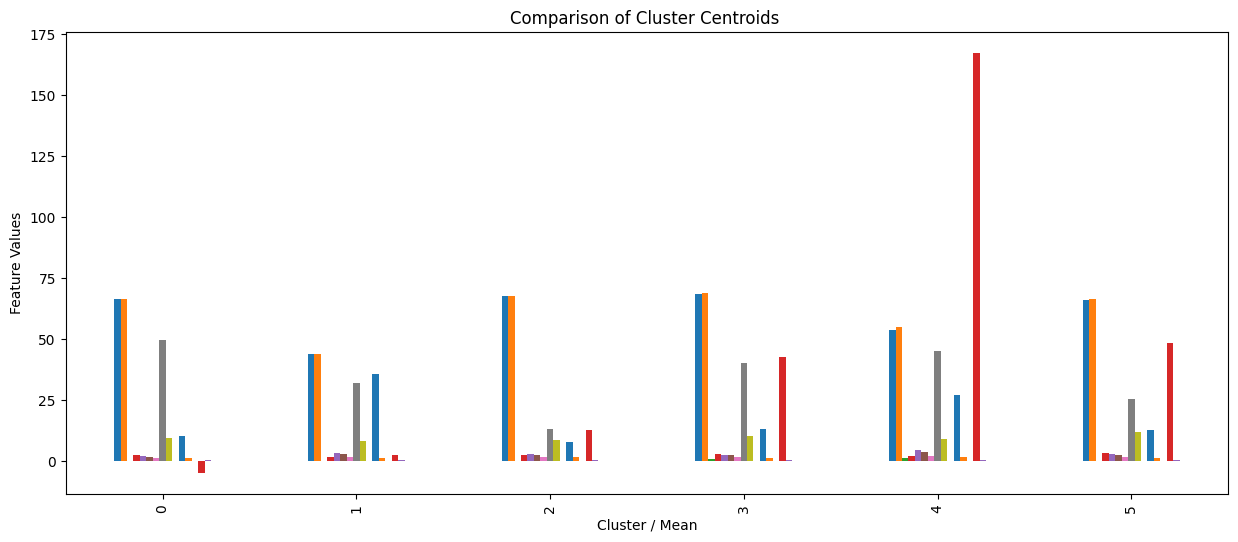

In [28]:
centroids_df_prefixed = Original_centroids_df.add_prefix('Centroid_')

# Selecting only the numeric columns from centroids_comparison_df
numeric_columns = centroids_df_prefixed.select_dtypes(include='number').columns
# Plotting the selected numeric columns
centroids_df_prefixed[numeric_columns].plot(kind='bar', figsize=(15, 6),legend=False)
plt.title('Comparison of Cluster Centroids ')
plt.xlabel('Cluster / Mean')
plt.ylabel('Feature Values')
plt.show()


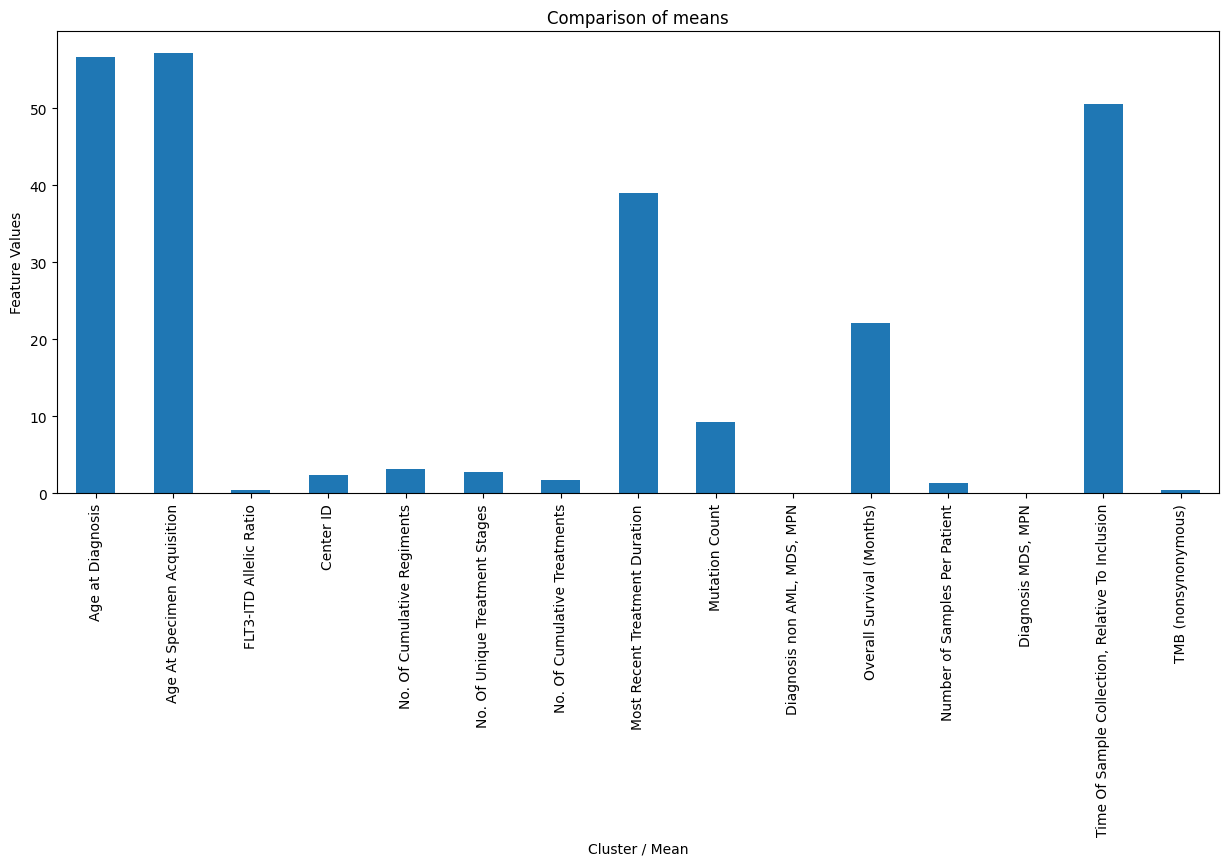

In [29]:
# Calculate the mean of the original data
original_means = pd.Series(df_cleaned.mean(axis=0, numeric_only=True))
original_means.index.name = 'MEANS'
means_df_prefixed = pd.DataFrame(original_means).add_prefix('Mean_')
means_df_prefixed.shape
means_df_prefixed.plot(kind='bar', figsize=(15, 6),legend=False)
plt.title('Comparison of means')
plt.xlabel('Cluster / Mean')
plt.ylabel('Feature Values')
plt.show()


# Recap:
- analysing the loadings we can extract which features were more important for that component (and if most relevant are related they can be used for describing a pattern)
- extracting the centroid, is used to see which is the average behavior, and comparing with the mean behaviour we can see how a given segment(cluster) differentiate from the "normal" behaviour;

see practical example!
https://drlee.io/the-ultimate-step-by-step-guide-to-data-mining-with-pca-and-kmeans-83a2bcfdba7d